
To address RQ1, we ran a Topic Modeling, unsupervised learning. We built a basic topic model using Gensim’s LDA and MALLET. Then, we built mallet’s LDA implementation. You saw how to find the optimal number of topics using coherence scores.


In [ ]:
!pip install --user -U regex

In [ ]:

## https://github.com/maria-antoniak/little-mallet-wrapper
## https://github.com/rsreetech/LDATopicModelling
## https://github.com/shingkid/data-mining-suicide-sg/

## The provided code in the following is used from the above URLs:

# Run in python console
import sys
import nltk;
nltk.download('stopwords')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\argha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

- For Topic Modeling we used Gensim library
- For lemmatization we used spaCy

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Import Dataset
df = pd.read_csv(r'path/to/Data/CodeEditorProjectsdata_English.csv')



In [ ]:
# Convert to list
data = df.issue_content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

#data = [re.sub('\S+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

#pprint(data[:1])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

#print(data_words[:1])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases. 

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)


In [ ]:
# Define functions for stopwords, bigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

    
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#print("Data:", data_words_bigrams)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])


# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

C:\Users\argha\AppData\Roaming\Python\Python38\site-packages\spacy\util.py:865: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[['hello_world', 'consider']]
[[(0, 1), (1, 1)]]


[[('consider', 1), ('hello_world', 1)]]

In [ ]:
# Build LDA model baseline 
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the baseline topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.000*"arduinojava" + 0.000*"ceeee" + 0.000*"importedall" + '
  '0.000*"uncleargithub" + 0.000*"cedebadc" + 0.000*"inscopes" + '
  '0.000*"apiconnecttool" + 0.000*"apilanguage" + '
  '0.000*"browser_settingseditorl" + 0.000*"beastcoder"'),
 (1,
  '0.078*"extension" + 0.064*"work" + 0.045*"reproduce" + 0.038*"step" + '
  '0.030*"try" + 0.028*"click" + 0.027*"show" + 0.024*"start" + 0.023*"select" '
  '+ 0.021*"time"'),
 (2,
  '0.449*"debug" + 0.129*"console" + 0.087*"crash" + 0.083*"tree" + '
  '0.059*"log" + 0.024*"reopen" + 0.016*"day" + 0.007*"reinstall" + '
  '0.006*"snap" + 0.003*"selecting"'),
 (3,
  '0.142*"change" + 0.078*"setting" + 0.075*"theme" + 0.075*"color" + '
  '0.069*"javascript" + 0.067*"apple" + 0.054*"bar" + 0.054*"format" + '
  '0.044*"know" + 0.042*"syntax"'),
 (4,
  '0.160*"folder" + 0.136*"project" + 0.111*"git" + 0.085*"terminal" + '
  '0.050*"remove" + 0.047*"document" + 0.045*"directory" + 0.045*"shift" + '
  '0.040*"delete" + 0.036*"exist"'),
 (5,
  '

In [ ]:
## Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. 
## In my experience, topic coherence score, in particular, has been more helpful since it shows semantically relation of each cluster
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda) # a measure of how semantically related the content of each cluster. higher is the better.


Perplexity:  -17.62347814928454

Coherence Score:  0.42757875016318014


In [ ]:
## So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.
## If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

## You need to install and define MALLET on your system 
# # Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'path/to/mallet-2.0.8/mallet-2.0.8'})
mallet_path = 'path/to/mallet-2.0.8/mallet-2.0.8/bin/mallet' # update this path

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run in order to present coherence value for each cluster
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=50, step=1)

In [ ]:
# Print the coherence scores for each cluster

max_value = 0
max_topic = 0
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))
    value = round(cv, 6)
    if value > max_value:
        max_value = value
        max_topic = m
print("*"*90)
print("Num max Topics =", max_topic, " has Coherence Value of", round(max_value, 6))

Num Topics = 2  has Coherence Value of 0.60133
Num Topics = 3  has Coherence Value of 0.604077
Num Topics = 4  has Coherence Value of 0.601079
Num Topics = 5  has Coherence Value of 0.630663
Num Topics = 6  has Coherence Value of 0.630816
Num Topics = 7  has Coherence Value of 0.61904
Num Topics = 8  has Coherence Value of 0.624695
Num Topics = 9  has Coherence Value of 0.641392
Num Topics = 10  has Coherence Value of 0.632482
Num Topics = 11  has Coherence Value of 0.628476
Num Topics = 12  has Coherence Value of 0.625675
Num Topics = 13  has Coherence Value of 0.632961
Num Topics = 14  has Coherence Value of 0.636713
Num Topics = 15  has Coherence Value of 0.635623
Num Topics = 16  has Coherence Value of 0.629071
Num Topics = 17  has Coherence Value of 0.647358
Num Topics = 18  has Coherence Value of 0.640769
Num Topics = 19  has Coherence Value of 0.625094
Num Topics = 20  has Coherence Value of 0.656031
Num Topics = 21  has Coherence Value of 0.644515
Num Topics = 22  has Coherence

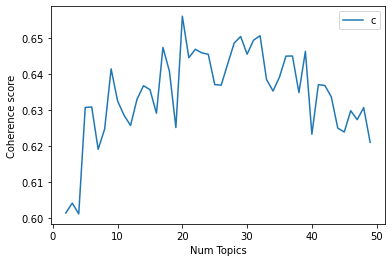

In [ ]:
# Show graph indicate the change of coherence value for each cluster
import matplotlib.pyplot as plt
%matplotlib inline

limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
import sys
!{sys.executable} -m pip install little_mallet_wrapper

In [ ]:
## https://github.com/maria-antoniak/little-mallet-wrapper/
## https://maria-antoniak.github.io/2022/07/27/topic-modeling-for-the-people.html

from collections import defaultdict
from datetime import datetime
import math
from operator import itemgetter
import os
import random
import re

import numpy as np
import pandas as pd

%matplotlib inline

import little_mallet_wrapper as lmw

path_to_mallet = 'path/to/mallet-2.0.8/mallet-2.0.8\bin/mallet'
output_directory_path = 'path/to/Data/' # change this to your directory for results
training_data = [lmw.process_string(t) for t in df['issue_content'].tolist()]
training_data = [d for d in training_data if d.strip()]
training_data = [data.encode('utf-8') for data in training_data]
training_data = [str(data) for data in training_data]

lmw.print_dataset_stats(training_data)

Number of Documents: 119280
Mean Number of Words per Document: 49.2
Vocabulary Size: 218378


In [ ]:
print(max_topic)
num_topics = max_topic
topic_keys, topic_distributions = lmw.quick_train_topic_model(path_to_mallet, output_directory_path,num_topics,training_data)

20
Importing data...
Complete
Training topic model...
Complete


In [ ]:
#assert(len(topic_distributions) == len(training_data))
print(topic_keys)

for i, t in enumerate(topic_keys):
    print(i, '\t', ' '.join(t[:30]))

for p, d in lmw.get_top_docs(training_data, topic_distributions, topic_index=0, n=3):
    print(round(p, 4), d)
    print()

[['app', 'lib', 'applications', 'contents', 'preview', 'resources', 'markdown', 'react', 'visual', 'studio', 'modules', 'framework', 'src', 'usr', 'node', 'share', 'main', 'html', 'getmac', 'libraries'], ['terminal', 'command', 'key', 'ctrl', 'editor', 'keyboard', 'path', 'linux', 'use', 'set', 'run', 'space', 'font', 'text', 'integrated', 'launch', 'open', 'task', 'tasks', 'default'], ['code', 'extensions', 'reproduce', 'issue', 'steps', 'version', 'windows', 'disabled', 'extension', 'yes', 'versionversion', 'file', 'typescript', 'type', 'intellisense', 'html', 'create', 'bug', 'error', 'php'], ['like', 'new', 'code', 'work', 'add', 'way', 'use', 'com', 'example', 'need', 'support', 'settings', 'request', 'want', 'feature', 'errors', 'view', 'default', 'option', 'extension'], ['githubusercontent', 'com', 'png', 'images', 'assets', 'imageuser', 'screen', 'gif', 'icon', 'screenshot', 'window', 'tab', 'imagecloud', 'color', 'shot', 'theme', 'weird', 'work', 'right', 'different'], ['atom'

In [ ]:
# num_topics = max_topic  # Change this to your result number of topics which has highest coherence value or any other prefererred number

path_to_training_data           = output_directory_path + '/trainingCodeEditorProjects.txt'
path_to_formatted_training_data = output_directory_path + '/mallet.trainingCodeEditorProjects'
path_to_model                   = output_directory_path + '/mallet.modelCodeEditorProjects.' + str(num_topics)
path_to_topic_keys              = output_directory_path + '/mallet.topic_keysCodeEditorProjects.' + str(num_topics)
path_to_topic_distributions     = output_directory_path + '/mallet.topic_distributionsCodeEditorProjects.' + str(num_topics)
path_to_word_weights            = output_directory_path + '/mallet.word_weightsCodeEditorProjects.' + str(num_topics)
path_to_diagnostics             = output_directory_path + '/mallet.diagnosticsCodeEditorProjects.' + str(num_topics) + '.xml'

In [ ]:
lmw.import_data(path_to_mallet,
                path_to_training_data,
                path_to_formatted_training_data,
                training_data)

Importing data...
Complete


In [ ]:
lmw.train_topic_model(path_to_mallet,
                      path_to_formatted_training_data,
                      path_to_model,
                      path_to_topic_keys,
                      path_to_topic_distributions,
                      path_to_word_weights,
                      path_to_diagnostics,
                      num_topics)

Training topic model...
Complete


In [ ]:
topic_keys = lmw.load_topic_keys(output_directory_path + '/mallet.topic_keysCodeEditorProjects.' + str(num_topics))

for i, t in enumerate(topic_keys):
    print(i, '\t', ' '.join(t[:30]))

0 	 code file html type syntax typescript function intellisense language json highlighting javascript create line reproduce like snippet css import files
1 	 com githubusercontent png images imageuser assets gif imagecloud screen screenshot shot jpg version testing like image shows atuser icon windows
2 	 system task squirrel string appdata runtime compilerservices taskawaiter local omnisharp boolean exception applyreleasesimpl app int path end trace stack thrown
3 	 open editor file click view tab menu window right bar new focus explorer tabs panel preview close action button context
4 	 commit date electronnode user com version data paste needed clipboard written setup issue mas send large code screen navigate keyboard
5 	 code extensions version extensionversion free windows process theme argv type issue novm bug info value remote status cpu intelcorei reproduces
6 	 debugging manualio flight hackingsections com checked safe http mode packages issue line aatom issues user aissue fol